# Полиномиальная регрессия

Как быть, когда ваша линейная регрессия показывает низкое качество, потому что данные не линейные, а более сложные?

Модель линейной регрессии можно сделать более гибкой, если использовать нелинейные функции от исходных предикторов – такой подход называется *полиномиальной регрессией*.

Чтобы лучше понять полиномиальную регресиию, давайте нарисуем графики трёх функций: $x$, $x^2$, $x^3$, а потом нарисуем новый график, который представляет собой их сумму $0.1x+2.5x^2+0.5x^3$ - сложим их с разными коэффициентами

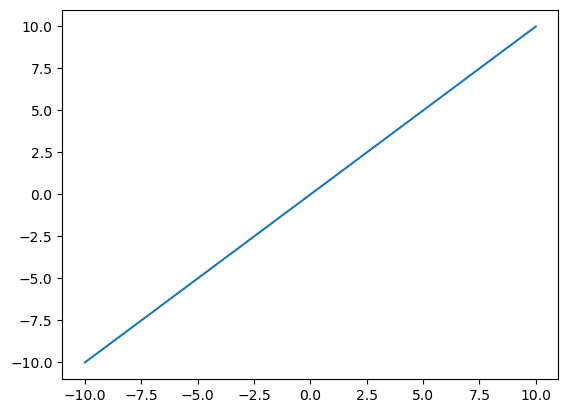

In [2]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

%matplotlib inline

x = np.linspace(-10, 10, num=100)

plt.plot(x,x)
plt.show()

Вторая степень

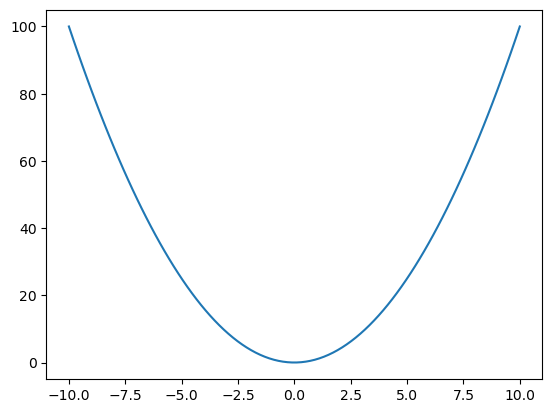

In [4]:
plt.plot(x,x**2)
plt.show()

Третья степень

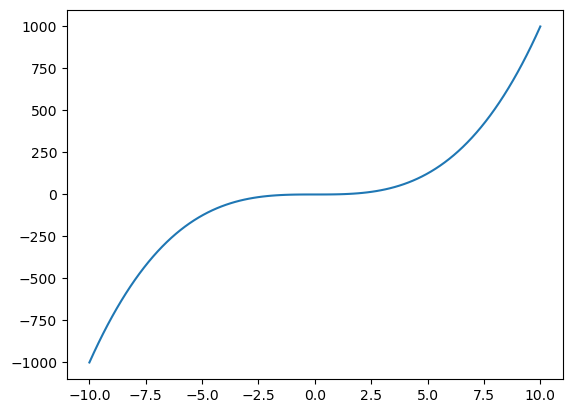

In [5]:
plt.plot(x,x**3)
plt.show()

Сумма трёх функций c с разными коэффициентами

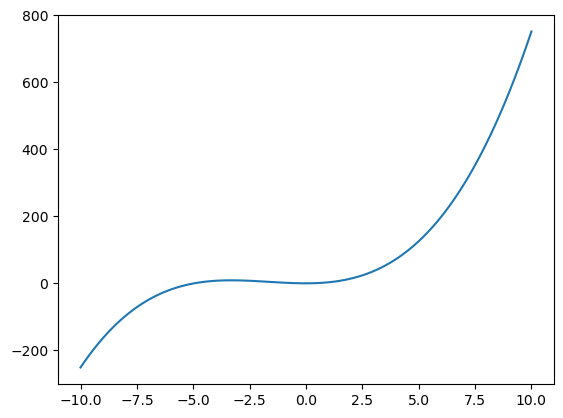

In [6]:
plt.plot(x, 0.5*x**3 + 2.5*x**2 + 0.1*x)
plt.show()

Как видно, новый график не похож ни на один из предыдущих – по входным данным $x$ мы получили причудливую загогулину – в этом и суть полиномиальной регрессии, мы можем сгенерировать несколько признаков из одного.

Для демонстрации принципов обучения нелинейной регресси загрузим датасет со сложной нелинейной зависимостью из csv файла.

In [9]:
data = pd.read_csv('3.10_non_linear.csv', sep=',')
data.head()

,x_train,y_train
0,0.138368,0.838812
1,0.157237,0.889313
2,0.188684,1.430040
3,0.685553,1.717309
4,0.874237,2.032588


Отобразим точки на графике – воспользуемся библиотекой [matplotlib](https://matplotlib.org/api/pyplot_api.html)

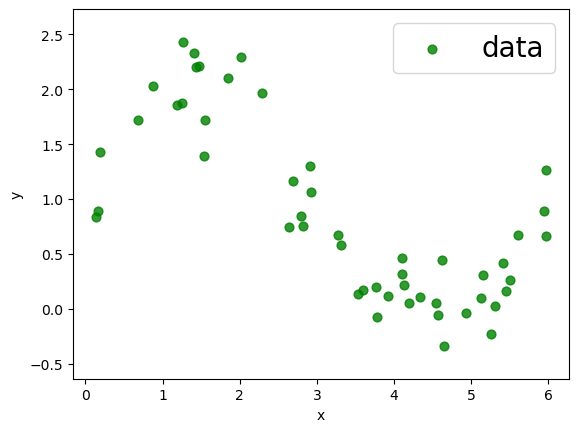

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline

margin = 0.3

# основной график
plt.scatter(data.x_train, data.y_train, 40, 'g', 'o', alpha=0.8, label='data')

# различные "украшения"
plt.xlim(data['x_train'].min() - margin, data['x_train'].max() + margin)
plt.ylim(data['y_train'].min() - margin, data['y_train'].max() + margin)
plt.legend(loc='upper right', prop={'size': 20})
plt.xlabel('x')
plt.ylabel('y')
plt.show()

Обучим линейную регрессию

In [13]:
from sklearn.linear_model import LinearRegression

reg = LinearRegression().fit(data[['x_train']], data.y_train)
y_hat = reg.predict(data[['x_train']])

Cтроим график решения (для наглядности)

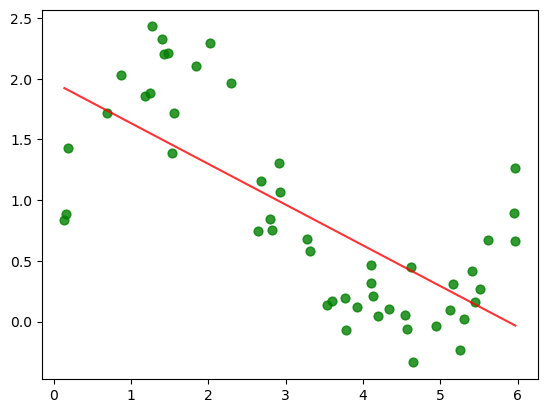

In [14]:
plt.scatter(data['x_train'], data['y_train'], 40, 'g', 'o', alpha=0.8)

plt.plot(data['x_train'], y_hat, 'r', alpha=0.8, label='fitted')

plt.show()

Мы построили линейную регрессию на одной переменной-предикторе, вся наша модель – это два значения $w = [w_0, w_1]$, которые задают уравнение прямой $y=w_1x+w_0$. Модель получилась довольно ограниченной, поэтому добавим немного нелинейных преобразований исходной переменной $x$. Напишем вспомогательную функцию, которая принимает на вход вектор-столбец $x$ и степень полинома, а возвращает матрицу, в которой каждая колонка представляет собой элемент вектора-столбца $x$ в нужной степени. Пример работы функции:

In [15]:
def generate_degrees(source_data: list, degree: int):
    """Функция, которая принимает на вход одномерный массив, а возвращает n-мерный

    Для каждой степени от 1 до  degree возводим x в эту степень
    """
    return np.array([
          source_data**n for n in range(1, degree + 1)
    ]).T

Например, сгенерируем для наших исходных данных все степени, вплоть до пятой

In [23]:
degree = 5

X = generate_degrees(data['x_train'], degree)

print(X.shape)

(50, 5)


array([[1.38368445e-01, 1.91458266e-02, 2.64917826e-03, 3.66562677e-04,
        5.07207077e-05],
       [1.57236870e-01, 2.47234331e-02, 3.88743523e-03, 6.11248147e-04,
        9.61107451e-05],
       [1.88684243e-01, 3.56017437e-02, 6.71748808e-03, 1.26748416e-03,
        2.39154289e-04],
       [6.85552751e-01, 4.69982575e-01, 3.22197847e-01, 2.20883621e-01,
        1.51427374e-01],
       [8.74236995e-01, 7.64290323e-01, 6.68170875e-01, 5.84139698e-01,
        5.10676534e-01],
       [1.18242126e+00, 1.39812003e+00, 1.65316685e+00, 1.95473963e+00,
        2.31132569e+00],
       [1.25160548e+00, 1.56651628e+00, 1.96066037e+00, 2.45397326e+00,
        3.07140638e+00],
       [1.27047391e+00, 1.61410395e+00, 2.05067694e+00, 2.60533155e+00,
        3.31000575e+00],
       [1.40255288e+00, 1.96715457e+00, 2.75903830e+00, 3.86969711e+00,
        5.42745481e+00],
       [1.42771078e+00, 2.03835806e+00, 2.91018576e+00, 4.15490357e+00,
        5.93200060e+00],
       [1.47173710e+00, 2.1660

То есть для $\text{degree}=5$ получили матрицу с числом колонок $5$. То есть из одной фичи мы делаем $n$ фичей, где $n$ – размерность полинома. Давайте посмотрим, как выглядит линейная регрессия, обученная на полиномах различных степеней. Для этого напишем функцию (чтобы не копипастить код) которая не делает ничего сложного:
* генерит данные для заданной степени полинома
* обучает модель
* строит график решения

In [29]:
from sklearn.metrics import mean_squared_error

def train_polynomial(degree, data):
    """Генерим данные, тренируем модель

    дополнительно рисуем график
    """

    X = generate_degrees(data['x_train'], degree)

    model = LinearRegression().fit(X, data['y_train'])
    y_pred = model.predict(X)

    error = mean_squared_error(data['y_train'], y_pred)
    print("Степень полинома %d Ошибка %.3f" % (degree, error))

    plt.scatter(data['x_train'], data['y_train'], 40, 'g', 'o', alpha=0.8, label='data')
    plt.plot(data['x_train'], y_pred)
    

Основная задача – подобрать ту степень полинома, которая будет уменьшать размер ошибки

В реальных задачах "глазами" ничего не понять – потому что в реальных задачах могут быть десятки переменных, уже нельзя просто глазами контролировать, как наша прямая ляжет в облако точек. Поэтому ориентироваться можно только на  какую-то метрику (например RMSE).

Давайте посмотрим, как  ошибка связана со степенью полинома

Степень 2

Степень полинома 2 Ошибка 0.298


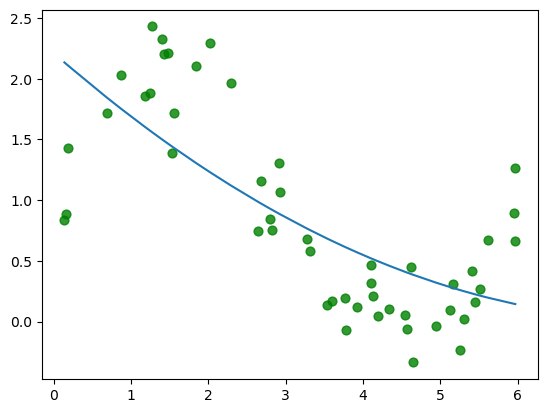

In [24]:
degree = 2

train_polynomial(degree, data)

Степень 3

Степень полинома 3 Ошибка 0.071


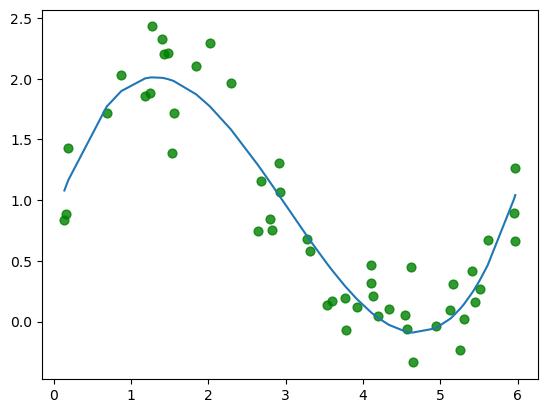

In [25]:
degree = 3

train_polynomial(degree, data)

Степень 5

Степень полинома 5 Ошибка 0.067


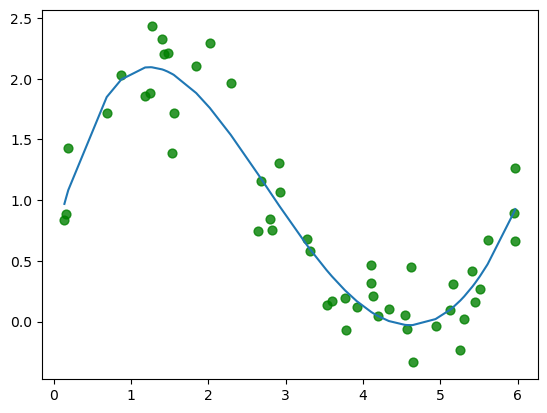

In [26]:
degree = 5

train_polynomial(degree, data)

Степень 11

Степень полинома 11 Ошибка 0.058


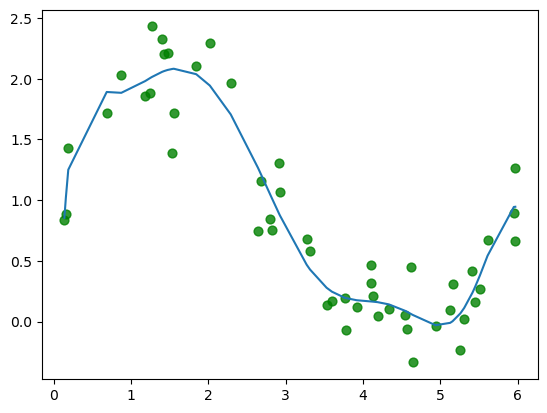

In [27]:
degree = 11

train_polynomial(degree, data)

Степень 25

Степень полинома 25 Ошибка 0.106


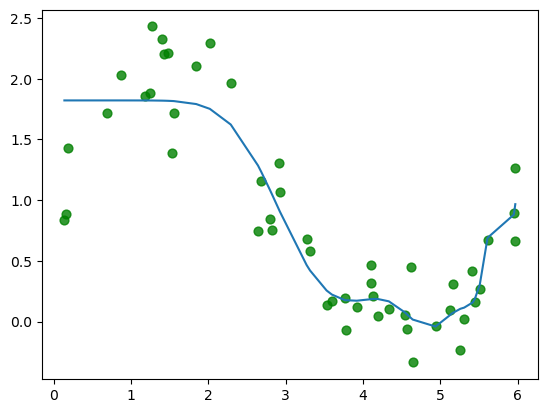

In [28]:
degree = 25

train_polynomial(degree, data)

Степень полинома 4 Ошибка 0.067


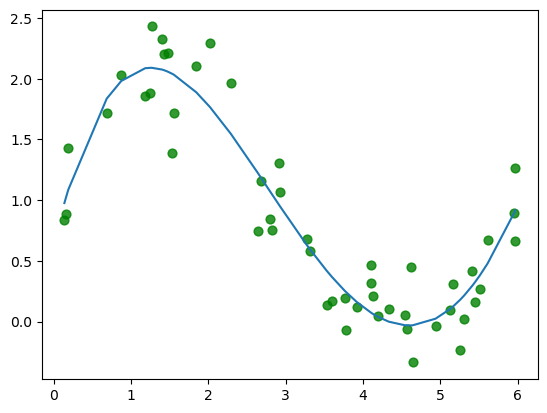

In [40]:
degree = 4

train_polynomial(degree, data)

Как видно, с ростом степени полинома ошибка сначала уменьшается, а потом снова начинает расти. Наша модель начинает описывать данные всё лучше и лучше, даже слишком хорошо – интуитивно понятно, что это снижает обобщающую способность модели, то есть новые данные модель будет предсказывать хуже, чем обучающую выборку.